In [2]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U",
    "pip", "setuptools", "wheel",
    "numpy", "pandas", "scikit-learn", "scipy", "statsmodels", "nltk", "tqdm", "ipywidgets"
])
print("설치 완료 → 커널 Restart 해주세요.")


설치 완료 → 커널 Restart 해주세요.


In [3]:
import nltk
nltk.download("vader_lexicon")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
# ============================================
# 텍스트 감성 테스트: AUC/LogLoss/Brier/pseudo-R²/LRT/p-value
# - with_features 있으면 사용, 없으면 원본에서 즉석 피처 생성 후 평가
# - 반드시 중간중간 프린트가 나오도록 구성됨
# ============================================

from pathlib import Path
import re, math, numpy as np, pandas as pd
import warnings; warnings.filterwarnings("ignore")

# ---------- (0) 경로 설정: 본인 PC 폴더로 바꾸세요 ----------
BASE = Path(r"C:\Users\user\Downloads\mscd\archive")  # ← 여기만 필요시 변경
PATH_WITH = BASE / "reallastdata_with_features.csv"
PATH_RAW  = BASE / "reallastdata.csv"

print("[PATH]", "with_features:", PATH_WITH.exists(), "raw:", PATH_RAW.exists())
if not PATH_WITH.exists() and not PATH_RAW.exists():
    raise FileNotFoundError(f"둘 다 없음:\n{PATH_WITH}\n{PATH_RAW}")

# ---------- (1) 유틸/간단 피처 함수 ----------
RE_WS = re.compile(r"\s+")
RE_SENT_SPLIT = re.compile(r"(?<=[\.!?])\s+")
POS = {"good","great","awesome","amazing","love","fun","enjoy","enjoyed","recommend","recommended","nice","cool","best","solid","worth","polished"}
NEG = {"bad","terrible","awful","hate","boring","buggy","broken","refund","waste","trash","garbage","lag","lags","laggy","crash","crashes","expensive","overpriced","greedy","paywall","not worth","disappoint","disappointed","scam"}

def normalize_text(s: str) -> str:
    if s is None: return ""
    s = str(s).replace("\u3000"," ").replace("\u200b","")
    s = "".join(ch for ch in s if ch.isprintable() or ch in "\n\t ")
    return s

def basic_stats(t: str):
    n = len(t)
    ascii_letters = sum(1 for ch in t if ("a"<=ch<="z") or ("A"<=ch<="Z"))
    hangul_cjk = sum(1 for ch in t if (
        ("\u1100"<=ch<="\u11FF") or ("\u3130"<=ch<="\u318F") or ("\uAC00"<=ch<="\uD7AF") or
        ("\u4E00"<=ch<="\u9FFF") or ("\u3400"<=ch<="\u4DBF") or
        ("\u3040"<=ch<="\u309F") or ("\u30A0"<=ch<="\u30FF")))
    excl = t.count("!")
    words = RE_WS.split(t.strip()) if t.strip() else []
    sents = RE_SENT_SPLIT.split(t.strip()) if t.strip() else []
    return {
        "len_chars": n,
        "word_count": float(len(words)),
        "sentence_count": float(len([s for s in sents if s])),
        "ascii_letter_ratio": (ascii_letters/n) if n else 0.0,
        "hangul_cjk_ratio": (hangul_cjk/n) if n else 0.0,
        "punct_exclaim_ratio": (excl/max(n,1)),
    }

def is_english_heur(stats: dict, lang_val: str) -> float:
    if lang_val:
        lv = str(lang_val).strip().lower()
        if "english" in lv: return 1.0
        if any(k in lv for k in ["korean","koreana","kore"]): return 0.0
    return 1.0 if (stats["ascii_letter_ratio"]>=0.4 and stats["hangul_cjk_ratio"]<=0.15) else 0.0

def sentiment_compound(t: str, english_flag: float) -> float:
    # 영어가 아니면 0
    if english_flag < 0.5:
        return 0.0
    # VADER 없이도 동작하는 백업 사전 방식 (오프라인)
    tl = t.lower()
    words = RE_WS.split(tl.strip()) if tl.strip() else []
    pos = sum(1 for w in words if w in POS)
    neg = sum(1 for w in words if w in NEG)
    total = max(1, len(words))
    pos_s = min(1.0, pos/total*5.0)
    neg_s = min(1.0, neg/total*5.0)
    return max(-1.0, min(1.0, pos_s - neg_s))

def to01(x):
    if x is None: return np.nan
    v = str(x).strip().lower()
    if v in ("1","true","t","yes","y","recommended","positive"): return 1
    if v in ("0","false","f","no","n","not_recommended","negative"): return 0
    try: return 1 if float(v)>0 else 0
    except: return np.nan

def num(x):
    try: return float(x)
    except: return np.nan

# ---------- (2) 데이터 준비 ----------
USE_WITH = PATH_WITH.exists()
print("[LOAD] with_features 사용?", USE_WITH)

NEEDED_COLS = ["translated_en","language","voted_up",
               "author_playtime_forever","author_playtime_at_review","author_playtime_last_two_weeks"]

if USE_WITH:
    # 이미 피처가 있으면 그대로 활용 (없을 수도 있으니 안전하게 보정)
    df = pd.read_csv(PATH_WITH, dtype=str, on_bad_lines="skip", encoding="utf-8")
    print("[READ] with_features rows:", len(df))
    # 최소 필요 피처 없으면 생성
    need_min = ["len_chars","is_english_heur","sent_compound"]
    if not set(need_min).issubset(set(df.columns)):
        print("[INFO] with_features에 최소 피처가 없어 즉석 생성")
        df["translated_en"] = df["translated_en"].astype(str).map(normalize_text)
        def row_min_feats(r):
            t = str(r.get("translated_en",""))
            st = basic_stats(t)
            eng = is_english_heur(st, str(r.get("language","")))
            sc = sentiment_compound(t, eng)
            return pd.Series({"len_chars":st["len_chars"], "is_english_heur":eng, "sent_compound":sc})
        df = pd.concat([df, df.apply(row_min_feats, axis=1)], axis=1)
else:
    # 원본에서 필요한 최소 열만 로드 → 즉석 피처 생성
    usecols = [c for c in NEEDED_COLS if (PATH_RAW.exists())]
    df = pd.read_csv(PATH_RAW, dtype=str, on_bad_lines="skip", encoding="utf-8")
    print("[READ] raw rows:", len(df))
    if "translated_en" not in df.columns:
        raise KeyError("원본에 'translated_en' 컬럼이 필요합니다.")
    # 즉석 피처 생성 (벡터화)
    tt = df["translated_en"].astype(str).map(normalize_text)
    stats = tt.map(basic_stats)
    df_stats = pd.DataFrame(list(stats))
    engflag = [is_english_heur(s, str(lv)) for s, lv in zip(df_stats.to_dict("records"), df.get("language","").astype(str).tolist())]
    df["len_chars"] = df_stats["len_chars"]
    df["is_english_heur"] = engflag
    # 감성 (빠르게 벡터라이즈)
    def quick_sc(text, eflag):
        return sentiment_compound(text, float(eflag))
    df["sent_compound"] = [quick_sc(t, e) for t, e in zip(tt.tolist(), engflag)]

print("[CHECK] columns available:", list(df.columns)[:15], "...")

# ---------- (3) 학습/평가 데이터셋 구성 ----------
y = df["voted_up"].map(to01).astype("float32") if "voted_up" in df.columns else None
if y is None or y.isna().all():
    raise KeyError("voted_up 타깃이 없어 감성 설명력 평가를 할 수 없습니다.")

# 컨트롤(길이/영어여부/플레이타임 로그)
X = pd.DataFrame({
    "len_chars": df.get("len_chars", pd.Series([np.nan]*len(df))).map(num),
    "is_english_heur": df.get("is_english_heur", pd.Series([0]*len(df))).map(num),
    "sent_compound": df.get("sent_compound", pd.Series([0]*len(df))).map(float),
})

for pt in ["author_playtime_forever","author_playtime_at_review","author_playtime_last_two_weeks"]:
    if pt in df.columns:
        X["log_playtime"] = np.log1p(df[pt].map(num).clip(lower=0))
        break
if "log_playtime" not in X.columns:
    X["log_playtime"] = 0.0

mask = ~y.isna() & X.notna().all(axis=1)
X = X.loc[mask].copy(); y = y.loc[mask].astype(int).copy()
print(f"[DATA] usable rows: {len(X):,} / total {len(df):,}")

# 표준화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# train/test split
from sklearn.model_selection import train_test_split
Xtr, Xte, ytr, yte = train_test_split(X_scaled, y, test_size=0.25, random_state=7, stratify=y)
print("[SPLIT] train:", len(Xtr), "test:", len(Xte))

# ---------- (4) 학습/지표 ----------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss

base_cols = ["len_chars","is_english_heur","log_playtime"]
full_cols = base_cols + ["sent_compound"]

def fit_metrics(cols):
    lr = LogisticRegression(max_iter=500, solver="liblinear", class_weight="balanced")
    lr.fit(Xtr[cols], ytr)
    proba = lr.predict_proba(Xte[cols])[:,1]
    auc = roc_auc_score(yte, proba)
    ll  = log_loss(yte, proba, labels=[0,1])
    br  = brier_score_loss(yte, proba)
    return auc, ll, br, proba

auc_b, ll_b, br_b, pb = fit_metrics(base_cols)
auc_f, ll_f, br_f, pf = fit_metrics(full_cols)

print("\n==== 성능 지표 ====")
print(f"[베이스라인]   AUC={auc_b:.3f}  LogLoss={ll_b:.3f}  Brier={br_b:.3f}")
print(f"[감성 추가]    AUC={auc_f:.3f}  LogLoss={ll_f:.3f}  Brier={br_f:.3f}")
print(f"[Δ]            AUC={auc_f-auc_b:+.3f}  LogLoss={ll_f-ll_b:+.3f}  Brier={br_f-br_b:+.3f}")

# ---------- (5) 통계적 유의성 (pseudo-R², 계수 p, LRT) ----------
try:
    import statsmodels.api as sm
    X_all = X_scaled
    def sm_fit(cols):
        Xc = sm.add_constant(X_all[cols], has_constant="add")
        m = sm.Logit(y, Xc).fit(disp=0)
        pr2 = 1 - (m.llf / m.llnull)  # McFadden pseudo-R²
        return m, pr2

    m_base, pr2_base = sm_fit(base_cols)
    m_full, pr2_full = sm_fit(full_cols)

    coef = m_full.params.get("sent_compound", np.nan)
    se   = m_full.bse.get("sent_compound", np.nan)
    pval = m_full.pvalues.get("sent_compound", np.nan)
    OR   = math.exp(coef) if not math.isnan(coef) else np.nan
    lo   = math.exp(coef - 1.96*se) if (not math.isnan(coef) and not math.isnan(se)) else np.nan
    hi   = math.exp(coef + 1.96*se) if (not math.isnan(coef) and not math.isnan(se)) else np.nan

    LR = 2*(m_full.llf - m_base.llf)
    from scipy.stats import chi2
    p_LRT = 1 - chi2.cdf(LR, df=(len(m_full.params)-len(m_base.params)))

    print("\n==== 설명력/유의성 ====")
    print(f"pseudo-R² (Base) = {pr2_base:.4f}")
    print(f"pseudo-R² (Full) = {pr2_full:.4f}  Δ={pr2_full-pr2_base:+.4f}")
    print(f"coef(sent_compound) = {coef:.4f}  (OR={OR:.3f}, 95%CI [{lo:.2f},{hi:.2f}], p={pval:.3g})")
    print(f"LRT(Base vs Full): LR={LR:.2f}, p={p_LRT:.3g}")
except Exception as e:
    print("\n[경고] statsmodels/chi2 가 없어 유의성 표시는 생략합니다.")
    print("에러 메시지:", repr(e))

# ---------- (6) 샘플 확인 ----------
print("\n==== 샘플 5행 (텍스트·감성) ====")
show_cols = [c for c in ["translated_en","language","sent_compound","len_chars","is_english_heur","voted_up"] if c in df.columns]
print(df.loc[X.index[:5], show_cols].to_string(index=False))

print("\n[DONE]")


[PATH] with_features: False raw: True
[LOAD] with_features 사용? False
[READ] raw rows: 188273
[CHECK] columns available: ['\ufeff"\ufeff""recommendationid"""', 'appid', 'game', 'author_steamid', 'author_num_games_owned', 'author_num_reviews', 'author_playtime_forever', 'author_playtime_last_two_weeks', 'author_playtime_at_review', 'author_last_played', 'language', 'review', 'timestamp_created', 'timestamp_updated', 'voted_up'] ...
[DATA] usable rows: 188,273 / total 188,273
[SPLIT] train: 141204 test: 47069

==== 성능 지표 ====
[베이스라인]   AUC=0.615  LogLoss=0.677  Brier=0.241
[감성 추가]    AUC=0.631  LogLoss=0.669  Brier=0.238
[Δ]            AUC=+0.016  LogLoss=-0.007  Brier=-0.003

==== 설명력/유의성 ====
pseudo-R² (Base) = 0.0204
pseudo-R² (Full) = 0.0292  Δ=+0.0088
coef(sent_compound) = 0.2929  (OR=1.340, 95%CI [1.32,1.36], p=5.89e-251)
LRT(Base vs Full): LR=1229.59, p=0

==== 샘플 5행 (텍스트·감성) ====
                                                                                                      

In [5]:
# ==========================
# 시각화 유틸 (matplotlib만 사용)
# ==========================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve

def plot_roc_curves(curves, y_true, title="ROC curves"):
    """
    curves: List[("이름", y_prob ndarray)]
    y_true: 0/1 ndarray
    """
    plt.figure(figsize=(6,5))
    for name, p in curves:
        fpr, tpr, _ = roc_curve(y_true, p)
        auc = roc_auc_score(y_true, p)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1], [0,1], "--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title); plt.legend(); plt.grid(True); plt.show()

def plot_calibration(name, y_true, y_prob, n_bins=10, title="Calibration"):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='quantile')
    plt.figure(figsize=(5,5))
    plt.plot(prob_pred, prob_true, marker="o", label=name)
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
    plt.title(title); plt.legend(); plt.grid(True); plt.show()

def plot_delta_auc(names, aucs, base_index=0, title="ΔAUC vs Base"):
    base = aucs[base_index]
    deltas = [a - base for a in aucs]
    plt.figure(figsize=(6,4))
    plt.bar(names, deltas)
    plt.axhline(0, lw=1)
    plt.title(title)
    plt.ylabel("ΔAUC")
    plt.grid(True, axis="y")
    plt.show()

def get_tfidf_coefs(logreg_model, tfidf_vectorizer, offset=0, n=None):
    """
    TF-IDF 계수만 추출 (조합 모델에서 앞부분이 TF-IDF라고 가정)
    offset: 시작 인덱스(보통 0)
    n     : TF-IDF 특성 수(보통 len(vocab))
    return: vocab(np.array[str]), coefs(np.array[float])
    """
    coef = logreg_model.coef_.ravel()
    vocab = tfidf_vectorizer.get_feature_names_out()
    if n is None:
        n = len(vocab)
    return vocab, coef[offset:offset+n]

def plot_token_importance(vocab, coefs, top_k=20, title_pos="Top + Tokens", title_neg="Top − Tokens"):
    idx_pos = np.argsort(coefs)[-top_k:][::-1]
    idx_neg = np.argsort(coefs)[:top_k]

    # Positive
    plt.figure(figsize=(7,6))
    y = np.arange(len(idx_pos))
    plt.barh(y, coefs[idx_pos])
    plt.yticks(y, vocab[idx_pos])
    plt.gca().invert_yaxis()
    plt.title(title_pos)
    plt.xlabel("Coefficient (LogReg)")
    plt.grid(True, axis="x")
    plt.show()

    # Negative
    plt.figure(figsize=(7,6))
    y = np.arange(len(idx_neg))
    plt.barh(y, coefs[idx_neg])
    plt.yticks(y, vocab[idx_neg])
    plt.gca().invert_yaxis()
    plt.title(title_neg)
    plt.xlabel("Coefficient (LogReg)")
    plt.grid(True, axis="x")
    plt.show()


In [6]:
from pathlib import Path
import re, numpy as np, pandas as pd

# ===== 경로 =====
BASE = Path(r"C:\Users\user\Downloads\mscd\archive")  # 필요시 수정
CSV  = BASE / "reallastdata.csv"
assert CSV.exists(), f"파일 없음: {CSV}"

# ===== 유틸 =====
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack

RE_WS = re.compile(r"\s+")
RE_SENT_SPLIT = re.compile(r"(?<=[\.!?])\s+")
POS = {"good","great","awesome","amazing","love","fun","enjoy","enjoyed","recommend","recommended","nice","cool","best","solid","worth","polished"}
NEG = {"bad","terrible","awful","hate","boring","buggy","broken","refund","waste","trash","garbage","lag","lags","laggy","crash","crashes","expensive","overpriced","greedy","paywall","not worth","disappoint","disappointed","scam"}
MONET_PAT = re.compile(
    r"\b(price|prices|pricy|pricing|sale|discount|dlc|microtransaction|microtransactions|mtx|"
    r"battle\s?pass|season\s?pass|cash\s?shop|loot\s?box|lootbox|gacha|pay\s*to\s*win|p2w|paywall|"
    r"refund|refunded|overpriced|expensive)\b", flags=re.IGNORECASE)
MONET_NEG_WORDS = {"overpriced","expensive","greedy","greed","predatory","scam","scummy","paywall","p2w","pay2win",
                   "not","no","isnt","isn't","wasnt","wasn't","dont","don't","doesnt","doesn't","worthless",
                   "waste","wasted","trash","garbage","refund","refunded","ripoff","rip-off","nickel","dime"}
TOXIC_WORDS = {"fuck","fucking","shit","wtf","trash","garbage","idiot","stupid","dumb","crap","bastard","bitch",
               "asshole","sucks","suck","moron","loser","retard","bullshit","bs"}
RE_TLDR   = re.compile(r"\btl;dr\b", re.IGNORECASE)
RE_PROS   = re.compile(r"\bpros\s*:\s*", re.IGNORECASE)
RE_CONS   = re.compile(r"\bcons\s*:\s*", re.IGNORECASE)
RE_BULLET = re.compile(r"^\s*[-*]\s+", re.MULTILINE)
RE_NUMBER = re.compile(r"^\s*\d+[\)\.\-]\s+", re.MULTILINE)
RE_HEADING= re.compile(r"^\s*#{1,6}\s+\S+", re.MULTILINE)

def pick_text_col(cols):
    for c in ["translated_en","review","text"]:
        if c in cols: return c
    raise KeyError("텍스트 컬럼 없음: translated_en / review / text 중 하나 필요")

def to01(x):
    if x is None: return np.nan
    v = str(x).strip().lower()
    if v in ("1","true","t","yes","y","recommended","positive"): return 1
    if v in ("0","false","f","no","n","not_recommended","negative"): return 0
    try: return 1 if float(v)>0 else 0
    except: return np.nan

def num(x):
    try: return float(x)
    except: return np.nan

def normalize_text(s: str) -> str:
    if s is None: return ""
    s = str(s).replace("\u3000"," ").replace("\u200b","")
    s = "".join(ch for ch in s if ch.isprintable() or ch in "\n\t ")
    return s

def basic_stats(t: str):
    n = len(t)
    ascii_letters = sum(1 for ch in t if ("a"<=ch<="z") or ("A"<=ch<="Z"))
    hangul_cjk = sum(1 for ch in t if (
        ("\u1100"<=ch<="\u11FF") or ("\u3130"<=ch<="\u318F") or ("\uAC00"<=ch<="\uD7AF") or
        ("\u4E00"<=ch<="\u9FFF") or ("\u3400"<=ch<="\u4DBF") or
        ("\u3040"<=ch<="\u309F") or ("\u30A0"<=ch<="\u30FF")))
    excl = t.count("!")
    words = RE_WS.split(t.strip()) if t.strip() else []
    sents = RE_SENT_SPLIT.split(t.strip()) if t.strip() else []
    return {
        "len_chars": n,
        "word_count": float(len(words)),
        "sentence_count": float(len([s for s in sents if s])),
        "ascii_letter_ratio": (ascii_letters/n) if n else 0.0,
        "hangul_cjk_ratio": (hangul_cjk/n) if n else 0.0,
        "punct_exclaim_ratio": (excl/max(n,1)),
    }

def is_english_heur(stats: dict, lang_val: str) -> float:
    if lang_val:
        lv = str(lang_val).strip().lower()
        if "english" in lv: return 1.0
        if any(k in lv for k in ["korean","koreana","kore"]): return 0.0
    return 1.0 if (stats["ascii_letter_ratio"]>=0.4 and stats["hangul_cjk_ratio"]<=0.15) else 0.0

def sentiment_compound(t: str, english_flag: float) -> float:
    if english_flag < 0.5: return 0.0
    tl = t.lower()
    words = RE_WS.split(tl.strip()) if tl.strip() else []
    pos = sum(1 for w in words if w in POS)
    neg = sum(1 for w in words if w in NEG)
    total = max(1, len(words))
    pos_s = min(1.0, pos/total*5.0)
    neg_s = min(1.0, neg/total*5.0)
    return max(-1.0, min(1.0, pos_s - neg_s))

def monetization_signal(text: str):
    tl = (text or "").lower()
    matches = list(MONET_PAT.finditer(tl))
    if not matches: return 0.0
    toks = RE_WS.split(tl); neg_hits = 0
    for m in matches:
        start = m.start(); acc=0; idx=0
        for i,t in enumerate(toks):
            acc += len(t)+1
            if acc>start: idx=i; break
        lo=max(0,idx-6); hi=min(len(toks),idx+7)
        if any(w in MONET_NEG_WORDS for w in toks[lo:hi]): neg_hits += 1
    neg_score = 1.0 if neg_hits>0 else 0.5
    return 0.5 + 0.5*neg_score

def toxicity_score(text: str, stats: dict):
    tl = (text or "").lower().strip()
    words = RE_WS.split(tl) if tl else []
    lex_density = (sum(1 for w in words if w in TOXIC_WORDS)/len(words)) if words else 0.0
    score = (0.6*lex_density + 0.25*stats["punct_exclaim_ratio"]*50.0 + 0.15*stats["ascii_letter_ratio"])
    return float(max(0.0, min(1.0, score)))

def structure_score(text: str):
    t = text or ""
    has_tldr = 1.0 if RE_TLDR.search(t) else 0.0
    has_pros = 1.0 if RE_PROS.search(t) else 0.0
    has_cons = 1.0 if RE_CONS.search(t) else 0.0
    list_bullets = float(len(RE_BULLET.findall(t)))
    list_numbers = float(len(RE_NUMBER.findall(t)))
    headings = float(len(RE_HEADING.findall(t)))
    return float(has_tldr + max(has_pros,0) + max(has_cons,0) + min(list_bullets,5.0) + min(list_numbers,5.0) + min(headings,5.0))

# ===== 데이터 로드/피처 =====
df = pd.read_csv(CSV, dtype=str, on_bad_lines="skip", encoding="utf-8")
text_col = pick_text_col(df.columns)
txt = df[text_col].astype(str).map(normalize_text)
y = df["voted_up"].map(to01).astype("float32")
assert not y.isna().all(), "voted_up 라벨이 필요합니다."

stats_list = txt.map(basic_stats)
stats_df = pd.DataFrame(list(stats_list))
engflag = [is_english_heur(s, str(lv)) for s, lv in zip(stats_df.to_dict("records"), df.get("language","").astype(str).tolist())]
sent = [sentiment_compound(t, float(e)) for t,e in zip(txt.tolist(), engflag)]
mon  = [monetization_signal(t) for t in txt]
tox  = [toxicity_score(t, s) for t,s in zip(txt.tolist(), stats_df.to_dict("records"))]
stru = [structure_score(t) for t in txt]

X_meta = pd.DataFrame({
    "len_chars": stats_df["len_chars"],
    "is_english_heur": engflag,
    "log_playtime": 0.0,
    "sent_compound": sent,
    "monetization_signal": mon,
    "toxicity_score": tox,
    "struct_score": stru,
})
for pt in ["author_playtime_forever","author_playtime_at_review","author_playtime_last_two_weeks"]:
    if pt in df.columns:
        X_meta["log_playtime"] = np.log1p(df[pt].map(num).clip(lower=0))
        break

mask = ~y.isna() & X_meta.notna().all(axis=1)
X_meta = X_meta.loc[mask].reset_index(drop=True)
Y = y.loc[mask].astype(int).reset_index(drop=True)
TXT = txt.loc[mask].reset_index(drop=True)

Xtr_meta, Xte_meta, y_train, y_test, tr_txt, te_txt = train_test_split(
    X_meta, Y, TXT, test_size=0.25, random_state=7, stratify=Y
)

scaler = StandardScaler()
def train_dense(Xtr_df, Xte_df, cols):
    Xtr = scaler.fit_transform(Xtr_df[cols])
    Xte = scaler.transform(Xte_df[cols])
    lr = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced")
    lr.fit(Xtr, y_train)
    prob = lr.predict_proba(Xte)[:,1]
    return lr, prob

# Base
cols_base = ["len_chars","is_english_heur","log_playtime"]
lr_base, prob_base = train_dense(Xtr_meta, Xte_meta, cols_base)

# + Sentiment
cols_full = cols_base + ["sent_compound"]
lr_full, prob_full = train_dense(Xtr_meta, Xte_meta, cols_full)

# TF-IDF
tfidf = TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=10, max_features=20000)
Xtr_tfidf = tfidf.fit_transform(tr_txt)
Xte_tfidf = tfidf.transform(te_txt)
lr_tfidf = LogisticRegression(max_iter=1500, solver="saga", penalty="l2", class_weight="balanced", n_jobs=-1)
lr_tfidf.fit(Xtr_tfidf, y_train)
prob_tfidf = lr_tfidf.predict_proba(Xte_tfidf)[:,1]

# TF-IDF + Topic(감성/과금/토식/구조화/메타)
dense_tr = scaler.fit_transform(Xtr_meta[["sent_compound","monetization_signal","toxicity_score","struct_score","len_chars","is_english_heur","log_playtime"]])
dense_te = scaler.transform(Xte_meta[["sent_compound","monetization_signal","toxicity_score","struct_score","len_chars","is_english_heur","log_playtime"]])
from scipy.sparse import csr_matrix, hstack
Xtr_combo = hstack([Xtr_tfidf, csr_matrix(dense_tr)], format="csr")
Xte_combo = hstack([Xte_tfidf, csr_matrix(dense_te)], format="csr")
lr_combo = LogisticRegression(max_iter=2000, solver="saga", penalty="l2", class_weight="balanced", n_jobs=-1)
lr_combo.fit(Xtr_combo, y_train)
prob_combo = lr_combo.predict_proba(Xte_combo)[:,1]

# 확인용 지표(프린트)
def metrics(y_true, y_prob):
    return (roc_auc_score(y_true, y_prob),
            log_loss(y_true, y_prob, labels=[0,1]),
            brier_score_loss(y_true, y_prob))
print("[OK] variables ready: prob_base, prob_full, prob_tfidf, prob_combo, y_test, tfidf, lr_combo")
for name, p in [("Base",prob_base),("+Sent",prob_full),("TF-IDF",prob_tfidf),("TF-IDF+Topic",prob_combo)]:
    auc,ll,br = metrics(y_test,p)
    print(f"{name:12s} AUC={auc:.3f}  LogLoss={ll:.3f}  Brier={br:.3f}")


[OK] variables ready: prob_base, prob_full, prob_tfidf, prob_combo, y_test, tfidf, lr_combo
Base         AUC=0.615  LogLoss=0.677  Brier=0.241
+Sent        AUC=0.631  LogLoss=0.669  Brier=0.238
TF-IDF       AUC=0.837  LogLoss=0.442  Brier=0.141
TF-IDF+Topic AUC=0.843  LogLoss=0.438  Brier=0.140


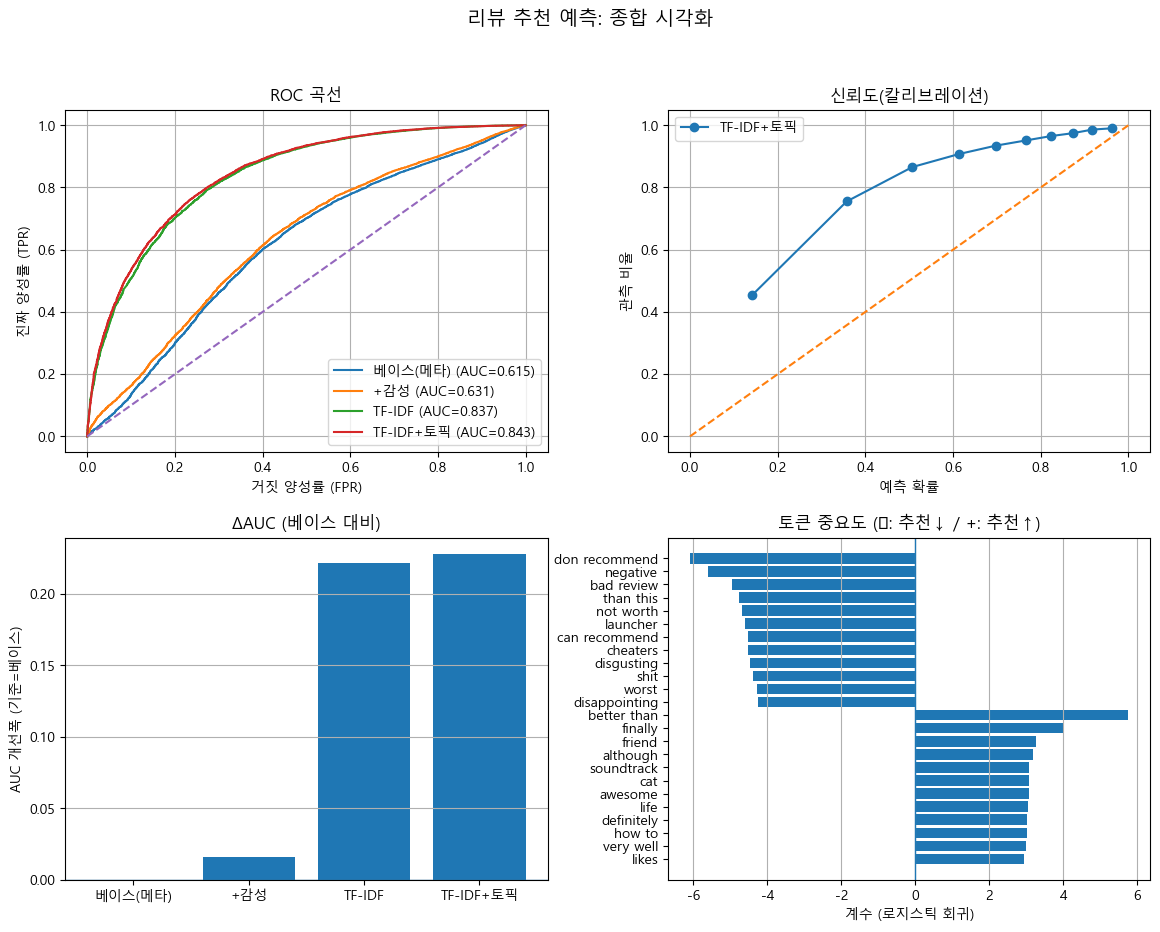

In [12]:
# ===== 종합 시각화(한 박스) : ROC + 신뢰도 + ΔAUC + 토큰중요도 =====
import numpy as np, platform, matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve

# (한글 폰트 설정)
def set_korean_font():
    if platform.system() == "Windows":
        rcParams["font.family"] = "Malgun Gothic"
    elif platform.system() == "Darwin":
        rcParams["font.family"] = "AppleGothic"
    else:
        rcParams["font.family"] = "NanumGothic"
    rcParams["axes.unicode_minus"] = False
set_korean_font()

# 0) 준비
names = ["베이스(메타)", "+감성", "TF-IDF", "TF-IDF+토픽"]
probs  = [prob_base, prob_full, prob_tfidf, prob_combo]
aucs   = [roc_auc_score(y_test, p) for p in probs]

fig = plt.figure(figsize=(14,10))
gs  = fig.add_gridspec(2, 2, hspace=0.25, wspace=0.25)
ax1 = fig.add_subplot(gs[0,0])  # ROC
ax2 = fig.add_subplot(gs[0,1])  # Calibration
ax3 = fig.add_subplot(gs[1,0])  # ΔAUC
ax4 = fig.add_subplot(gs[1,1])  # Token importance

# 1) ROC 곡선
for name, p in zip(names, probs):
    fpr, tpr, _ = roc_curve(y_test, p)
    ax1.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test,p):.3f})")
ax1.plot([0,1],[0,1],'--')
ax1.set_xlabel("거짓 양성률 (FPR)")
ax1.set_ylabel("진짜 양성률 (TPR)")
ax1.set_title("ROC 곡선")
ax1.legend(); ax1.grid(True)

# 2) 신뢰도(칼리브레이션)
prob_true, prob_pred = calibration_curve(y_test, prob_combo, n_bins=10, strategy='quantile')
ax2.plot(prob_pred, prob_true, marker="o", label="TF-IDF+토픽")
ax2.plot([0,1],[0,1],'--')
ax2.set_xlabel("예측 확률")
ax2.set_ylabel("관측 비율")
ax2.set_title("신뢰도(칼리브레이션)")
ax2.legend(); ax2.grid(True)

# 3) ΔAUC (베이스 대비 개선폭)
base_auc = aucs[0]
deltas = [a - base_auc for a in aucs]
ax3.bar(names, deltas)
ax3.axhline(0, linewidth=1)
ax3.set_ylabel("AUC 개선폭 (기준=베이스)")
ax3.set_title("ΔAUC (베이스 대비)")
ax3.grid(True, axis="y")

# 4) 토큰 중요도 (TF-IDF 계수: 음수=추천↓, 양수=추천↑)
coef  = lr_combo.coef_.ravel()
vocab = tfidf.get_feature_names_out()
k     = len(vocab)
coefs_tfidf = coef[:k]
top_k = 12
idx_pos = np.argsort(coefs_tfidf)[-top_k:][::-1]
idx_neg = np.argsort(coefs_tfidf)[:top_k]

tokens = list(vocab[idx_neg]) + list(vocab[idx_pos])
values = list(coefs_tfidf[idx_neg]) + list(coefs_tfidf[idx_pos])
ypos   = np.arange(len(tokens))

ax4.barh(ypos, values)
ax4.axvline(0, linewidth=1)
ax4.set_yticks(ypos)
ax4.set_yticklabels(tokens)
ax4.invert_yaxis()
ax4.set_xlabel("계수 (로지스틱 회귀)")
ax4.set_title("토큰 중요도 (−: 추천↓ / +: 추천↑)")
ax4.grid(True, axis="x")

fig.suptitle("리뷰 추천 예측: 종합 시각화", fontsize=14)
plt.tight_layout()
plt.show()


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss

# 파이프라인
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1,3),
        sublinear_tf=True,
        token_pattern=r"(?u)\b[\w']+\b"   # ' 보존
    )),
    ("clf", LogisticRegression(
        solver="saga",
        penalty="l2",
        class_weight="balanced",
        max_iter=3000,
        n_jobs=-1,
        random_state=7
    )),
])

# ★ 여기! 파라미터 키는 단계명__파라미터
param_grid = {
    "tfidf__min_df": [5, 10, 20],
    "tfidf__max_features": [30000, 40000, 60000],
    "clf__C": [0.5, 1.0, 2.0, 4.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
gs = GridSearchCV(pipe, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=1)
gs.fit(tr_txt, y_train)

p_tuned = gs.predict_proba(te_txt)[:,1]
print("[Best]", gs.best_params_, "AUC_CV≈", gs.best_score_)
print("AUC=", roc_auc_score(y_test, p_tuned),
      "LogLoss=", log_loss(y_test, p_tuned, labels=[0,1]),
      "Brier=", brier_score_loss(y_test, p_tuned))

# 나중 단계에서 쓰려고 베스트 구성 꺼내두기
best_tfidf = gs.best_estimator_.named_steps["tfidf"]
best_C     = gs.best_estimator_.named_steps["clf"].C


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Best] {'clf__C': 1.0, 'tfidf__max_features': 60000, 'tfidf__min_df': 10} AUC_CV≈ 0.8482677314402232
AUC= 0.8498309630102419 LogLoss= 0.4137711027542712 Brier= 0.12968863760916274


c:\Users\user\Downloads\mscd\archive\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


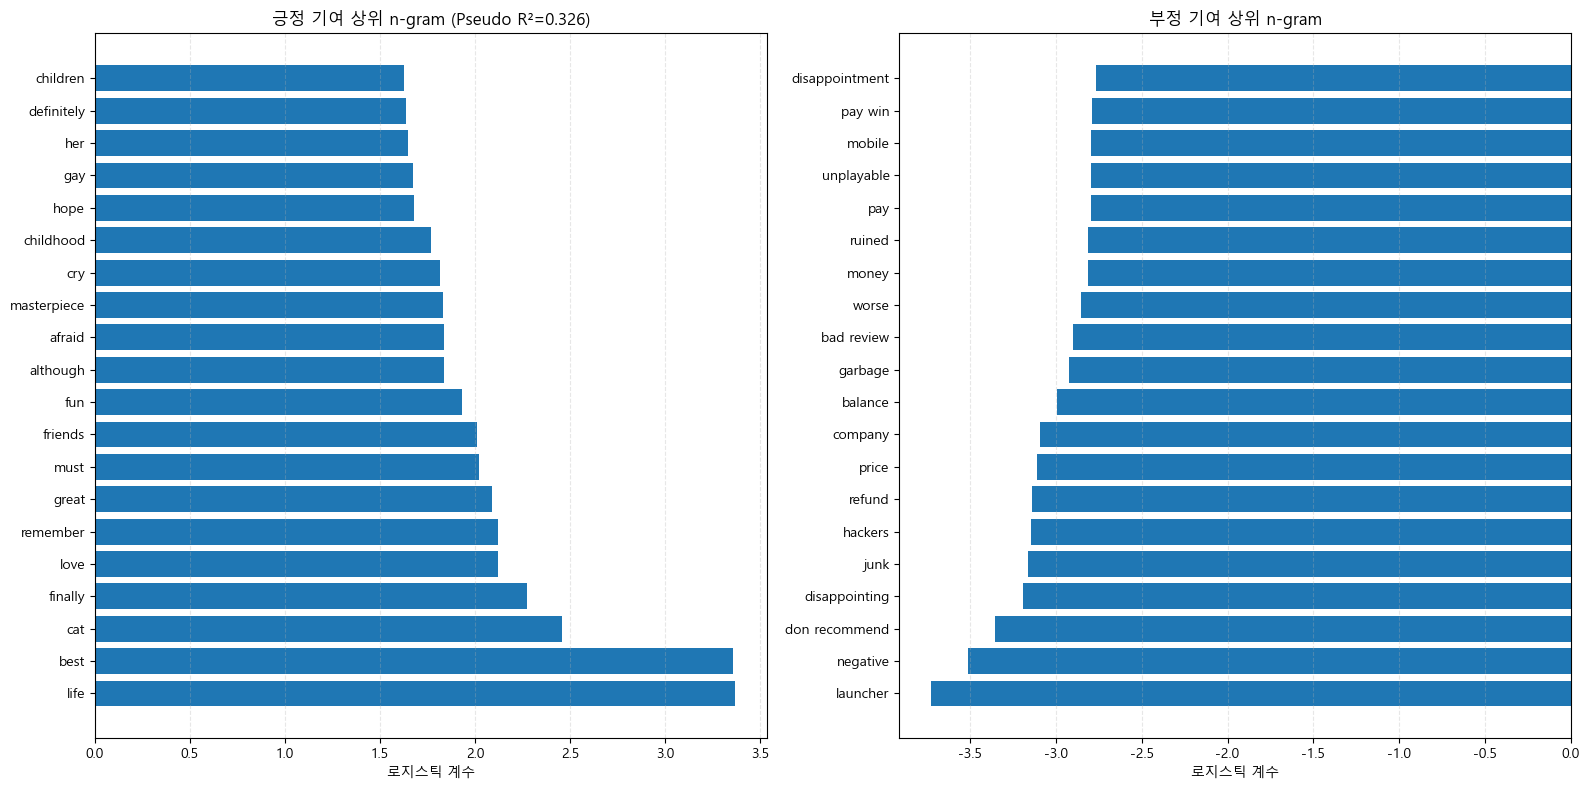

In [3]:
# -*- coding: utf-8 -*-
"""
필요 없는 단어 제거 + 한글 폰트 + matplotlib만 사용
상위 긍/부정 n-gram(로지스틱 계수 기준) 시각화 & CSV 저장
"""
import re, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss

# 0) 한글 폰트 자동 설정
cand = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR"]
installed = {f.name for f in font_manager.fontManager.ttflist}
for f in cand:
    if f in installed:
        rcParams["font.family"] = f
        break
rcParams["axes.unicode_minus"] = False

# 1) 데이터
df = pd.read_csv("reallastdata.csv", encoding="utf-8")
df.columns = df.columns.str.replace('"','',regex=False).str.replace("﻿","",regex=False).str.strip()
target = "voted_up"
text_col = "translated_en" if "translated_en" in df.columns else "review"
use = df[[target, text_col]].dropna()

MAX_N = 60000
if len(use) > MAX_N:
    use = use.sample(MAX_N, random_state=42)

# 2) 불용어 + 토크나이저
basic_stop = {
    "the","and","you","that","this","are","was","for","with","have","not","but","can","get","all","just",
    "your","they","will","has","its","had","out","one","too","more","very","there","than","then","into",
    "from","what","when","where","which","why","who","how","did","does","doing","done","got","been","being",
    "here","also","about","over","under","again","still","much","many","most","some","any","every","other",
    "would","should","could","able","really","even","ever","always","never","because","after","before",
    "game","games","play","played","playing","player","players","steam"  # 도메인 상시 등장 일반어
}
token_pat = re.compile(r"[a-zA-Z][a-zA-Z']{2,}")
def tokenize(s:str):
    return [t.lower() for t in token_pat.findall(str(s)) if t.lower() not in basic_stop]

# 3) TF-IDF + 로지스틱
tfidf = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,2), min_df=5, max_features=20000)
clf = LogisticRegression(max_iter=250, solver="saga", n_jobs=2)
pipe = Pipeline([("tfidf", tfidf), ("clf", clf)])

X = use[text_col].astype(str).values
y = use[target].astype(int).values
pipe.fit(X, y)

# 설명력 (McFadden Pseudo R²)
p = pipe.predict_proba(X)[:,1]
eps = 1e-12
ll_m = -len(y)*log_loss(y, np.clip(p, eps, 1-eps), labels=[0,1])
ll_0 = -len(y)*log_loss(y, np.full_like(y, y.mean(), dtype=float), labels=[0,1])
pseudo_r2 = 1 - (ll_m/ll_0)

# 상위/하위 n-gram
vec = pipe.named_steps["tfidf"]; lr = pipe.named_steps["clf"]
feat = vec.get_feature_names_out(); coef = lr.coef_.ravel()
TOPK = 20
idx_pos = np.argsort(coef)[-TOPK:][::-1]
idx_neg = np.argsort(coef)[:TOPK]

pos = pd.DataFrame({"feature": feat[idx_pos], "coef": coef[idx_pos]})
neg = pd.DataFrame({"feature": feat[idx_neg], "coef": coef[idx_neg]})

# 4) 시각화 (matplotlib)
def plot_hbar(df_plot, title, ax):
    y = np.arange(len(df_plot))[::-1]
    ax.barh(y, list(reversed(df_plot["coef"].tolist())))
    ax.set_yticks(y)
    ax.set_yticklabels(list(reversed(df_plot["feature"].tolist())))
    ax.set_title(title)
    ax.set_xlabel("로지스틱 계수")
    ax.grid(axis="x", linestyle="--", alpha=0.3)

fig, axes = plt.subplots(1, 2, figsize=(16,8))
plot_hbar(pos, f"긍정 기여 상위 n-gram (Pseudo R²={pseudo_r2:.3f})", axes[0])
plot_hbar(neg, "부정 기여 상위 n-gram", axes[1])
plt.tight_layout()
plt.show()

# # 5) CSV 저장
# pos.to_csv("top_positive_ngrams_clean.csv", index=False, encoding="utf-8")
# neg.to_csv("top_negative_ngrams_clean.csv", index=False, encoding="utf-8")
# print("Saved: top_positive_ngrams_clean.csv, top_negative_ngrams_clean.csv")
